In [126]:
import numpy as np
import qiskit.pulse as pulse
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.states import Statevector
from scipy.integrate import cumulative_trapezoid

这份文件的目标是实现Gaussian驱动下的单比特量子酉门。单比特酉门可以由$U=e^{i\alpha}R_x(\theta_1)R_y(\theta_2)R_x(\theta_3)$实现

In [127]:
# Start the qubit in its ground state.
ini_state = np.array([1,0])
y0 = Statevector(ini_state)

# Strength of the Rabi-rate in GHz.
r = 2*np.pi*0.1

# Frequency of the qubit transition in GHz.
w = 5.

# Sample rate of the backend in ns.
dt = 1 / 4.5

# construct operators
X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

#持续时间
T = 50 * dt
#持续duration个采样间隔
duration = int(T / dt)

drift = -2 * np.pi * w * Z/2
#H0
operators = [r * Y]
#Hd

# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2*w,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

In [128]:
def PlotEnveAndGetSignal(dt,xp,draw=False):
    converter = InstructionToSignals(dt, carriers={"d0": w})
    signals = converter.get_signals(xp)
    if (draw):
        plt.rcParams["font.size"] = 16
        fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
        for ax, title in zip(axs, ["envelope", "signal"]):
            signals[0].draw(0, 3*T, 2000, title, axis=ax)
            ax.set_xlabel("Time (ns)")
            ax.set_ylabel("Amplitude")
            ax.set_title(title)
    return signals
        
def plot_populations(sol):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]
    print(sol.y[-1])
    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
    plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, 3*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

In [129]:
def PrintAngle(signals,t_list):
    envelope=signals[0].envelope
    values = envelope(t_list)
    integral = cumulative_trapezoid(values, x=t_list, initial=0)
    return integral[-1]*r
    #R(a)->sin(a/2)
    
def FindGaussianAmp(target,duration,sig,t_list):
    left = 0; right = 1; amp = 0.5
    for i in range(100):
        with pulse.build(name="sx-sy schedule") as xp:
            pulse.play(pulse.Gaussian(duration,amp,sig), pulse.DriveChannel(0))    
        signal = PlotEnveAndGetSignal(dt,xp)
        Angle = PrintAngle(signal,t_list)
        if (Angle-target>0.000001):
            right = amp 
        elif (target-Angle>0.000001):
            left = amp
        else: return amp
        amp = (right+left)/2
    return -1

def Rx(theta):
    return np.array([[np.cos(theta/2),-1j*np.sin(theta/2)],
                     [-1j*np.sin(theta/2),np.cos(theta/2)]])
    
def Ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],
                     [-np.sin(theta/2),np.cos(theta/2)]])
    
def Rz(theta):
    return np.array([[np.exp(-1j*theta/2),0],
                     [0,np.exp(1j*theta/2)]])
    
def GlobalPhase(theta):
    phase = np.array([[np.exp(1j*theta/2),0],
                     [0,np.exp(1j*theta/2)]])
    #return Rz(theta)@phase
    return phase

In [130]:
Theta = np.pi/6
phi = np.pi/3
amp = 0.6
sig = 15
#积分的取点位置
t_list= np.linspace(0,T,1000)

Target_Amp= FindGaussianAmp(Theta,duration,sig,t_list)
print("the amp is: ",Target_Amp)

the amp is:  0.1273198127746582


CPU times: total: 18.4 s
Wall time: 19.2 s


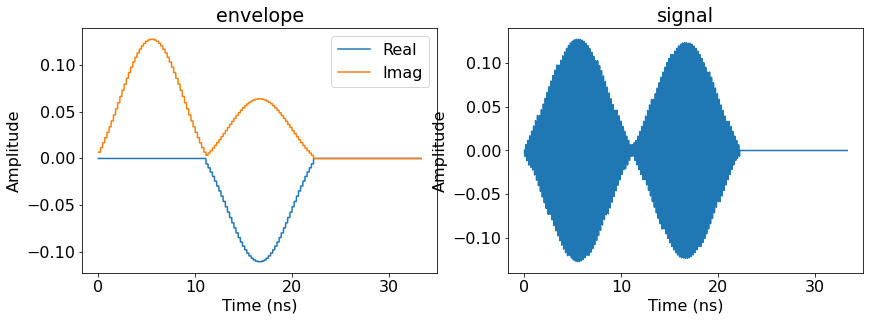

In [131]:
with pulse.build(name="sx-sy schedule") as xp:
    pulse.shift_phase(np.pi/2,channel=pulse.DriveChannel(0))
    #virtual Z gate!不影响保真度.如果不想要这个gate,可以把Hd换成r*X
    pulse.play(pulse.Gaussian(duration,Target_Amp,sig), pulse.DriveChannel(0))
    pulse.shift_phase(phi,channel=pulse.DriveChannel(0))
    pulse.play(pulse.Gaussian(duration,Target_Amp,sig), pulse.DriveChannel(0))
xp.draw() 

signal = PlotEnveAndGetSignal(dt,xp,True)
%time sol = hamiltonian_solver.solve(t_span=[0., 3*T], y0=y0, signals=signal, atol=1e-8, rtol=1e-8)

到此我们实现了$U=Z(-\phi)X(\Theta)Z(\phi)X(\Theta)$这个操作

[ 0.899519-0.058013j -0.216506-0.375j   ]
Statevector([ 0.89968957-0.05791425j, -0.21633511-0.37470485j],
            dims=(2,))


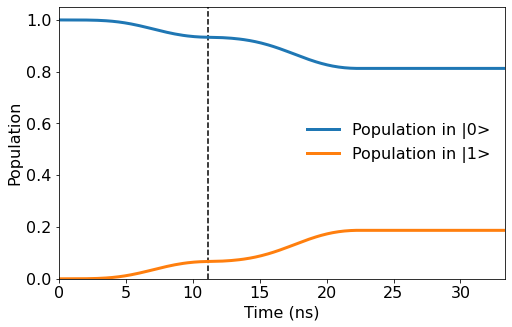

In [132]:
State2 = np.round(Rz(-phi)@Rx(Theta)@Rz(phi)@Rx(Theta)@ini_state,6)
print(State2)
plot_populations(sol)

对于$U(\theta,\phi,\lambda)=Z(\phi-\pi/2)X(\pi/2)Z(\pi-\theta)X(\pi/2)Z(\lambda-\pi/2)$

In [133]:
theta = np.pi/3
phi = np.pi/6
lamb = np.pi/4

t_list= np.linspace(0,T,1000)

Target_Amp= FindGaussianAmp(np.pi/2,duration,sig,t_list)
print("the amp is: ",Target_Amp)

the amp is:  0.3819594383239746


In [134]:
def U(theta,phi,lamb):
    return np.array([          [np.cos(theta/2),-np.exp(1j*lamb)*np.sin(theta/2)],
                [np.exp(1j*phi)*np.sin(theta/2),np.exp(1j*(phi+lamb))*np.cos(theta/2)]])

CPU times: total: 20.2 s
Wall time: 21.1 s


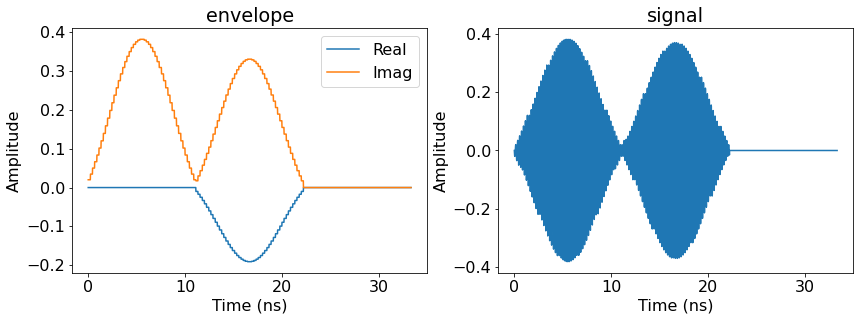

In [135]:
with pulse.build(name="sx-sy schedule") as xp:
    pulse.shift_phase(np.pi/2,channel=pulse.DriveChannel(0))
    #virtual Z gate!不影响保真度.如果不想要这个gate,可以把Hd换成r*X
    pulse.play(pulse.Gaussian(duration,Target_Amp,sig), pulse.DriveChannel(0))
    pulse.shift_phase(phi,channel=pulse.DriveChannel(0))
    pulse.play(pulse.Gaussian(duration,Target_Amp,sig), pulse.DriveChannel(0))
xp.draw() 

signal = PlotEnveAndGetSignal(dt,xp,True)
%time sol = hamiltonian_solver.solve(t_span=[0., 3*T], y0=y0, signals=signal, atol=1e-8, rtol=1e-8)